In [0]:
!pip -q install python_speech_features

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

In [0]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


##  Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/analysisFunctions.py

## Download Data

In [0]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Nothing to do.
Nothing to do.


In [0]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'], include_unknown=False)
testDF = getDataframe(dataDict['test'], include_unknown=False) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=False)

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(testDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 6835


In [0]:
from trainingUtils import getDatasetAutoencoder

BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 32000

train_data, train_steps = getDatasetAutoencoder(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_denoising_autoencoder_cache',
    shuffle=True,
    add_noise=True,
    scale=True
) 

val_data, val_steps = getDatasetAutoencoder(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_denoising_autoencoder_cache',
    shuffle=False,
    add_noise=False,
    scale=True
)

## Autoencoder

In [0]:
def simple_rnn_autoencoder(input_shape=(99, 40)):
    
    inputs = tf.keras.Input(shape=input_shape)
    
    encoded = tf.keras.layers.LSTM(80, activation='relu')(inputs)

    decoded = tf.keras.layers.RepeatVector(99)(encoded)
    decoded = tf.keras.layers.LSTM(40, return_sequences=True)(decoded)

    sequence_autoencoder = tf.keras.Model(inputs, decoded)
    encoder = tf.keras.Model(inputs, encoded)
    return sequence_autoencoder

In [0]:
def en_dec_rnn(input_shape=(99, 40)):
    '''
    Encoder/Decoder RNN
    
    Parameters\n
    input_shape (array): dimensions of the model input\n
    '''
    # Input Layer
    inputs = tf.keras.Input(shape = input_shape)
#     reshape = tf.keras.layers.Reshape(target_shape=(99, 40, 1))(inputs)
#     norm = tf.keras.layers.BatchNormalization()(reshape)
    
#     # Convolutional Layer
#     conv = tf.keras.layers.Conv2D(30, kernel_size=(3, 3),
#                                        padding='same', activation='relu')(norm)
#     batch = tf.keras.layers.BatchNormalization()(conv)
#     conv = tf.keras.layers.Conv2D(1, kernel_size=(3, 3),
#                                        padding='same', activation='relu')(batch)
#     batch = tf.keras.layers.BatchNormalization()(conv)
#     squeeze = tf.keras.layers.Lambda(
#         lambda x: tf.keras.backend.squeeze(x, -1), name='squeeze_dim')(batch)
    
    # Encoding Layer
    lstm = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(inputs)
    lstm = tf.keras.layers.LSTM(64, activation='relu', return_sequences=False)(lstm)
    
    # Decoding Layer
    repeat = tf.keras.layers.RepeatVector(99)(lstm)
    lstm = tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)(repeat)
    lstm = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(lstm)
    time_dist = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(40))(lstm)

    # Model
    model = tf.keras.Model(inputs=[inputs], outputs=[time_dist])
    return model

In [0]:
model = simple_rnn_autoencoder()
model.summary()

NameError: ignored

In [0]:
model = en_dec_rnn()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99, 40)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 99, 128)           86528     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 99, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 99, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 99, 40)            5160  

In [0]:
model.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam()
             )

In [0]:
EPOCHS = 80

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("bestRNNAE.h5",  monitor='val_loss', save_best_only=True)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])

Epoch 1/80
 155/1000 [===>..........................] - ETA: 11:34 - loss: 21981946670946740.0000

KeyboardInterrupt: ignored

In [0]:
model.save("RNNAE.h5")

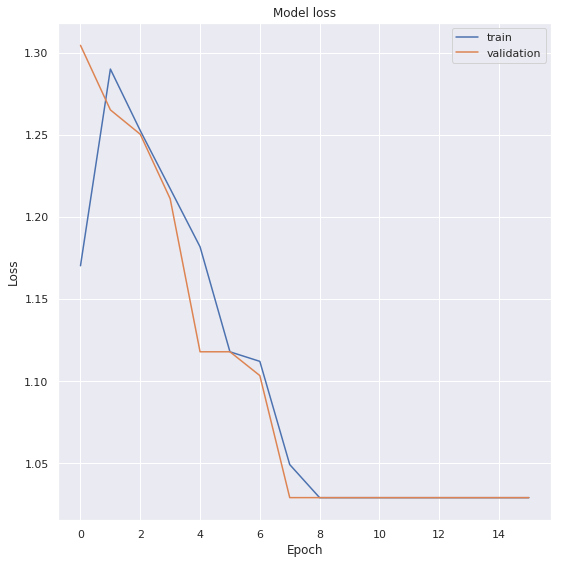

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax1 = plt.subplots(1,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

plt.tight_layout()
fig.show()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir /content/gdrive/My\ Drive/Colab\ Notebooks/RNNAutoencoders

mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab Notebooks/RNNAutoencoders’: File exists


In [0]:
GDRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/RNNAutoencoders/"

model.save(GDRIVE_PATH +"RNNAE.h5")
print("Saved model to drive")

Saved model to drive


In [0]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_results.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


## Test 

In [0]:
from tensorflow.keras.models import load_model

autoencoder = load_model("bestRNNAE.h5")

In [0]:
from trainingUtils import _loadWavs, _logMelFilterbank, getDataset, _scale
from python_speech_features import mfcc
import numpy as np

def _parse_fn_autoencoder_test(filename, label, nfilt=40, add_noise=True, scale=True):
    """
    Function used to compute filterbanks from file name
    """
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave, nfilt)
    #fbank = mfcc(wave)
    
    if scale:
        fbank = _scale(fbank)
    
    input_image = fbank
    if add_noise:
        input_image = fbank + 0.2*np.random.normal(0, 1, fbank.shape)
        
    return input_image, fbank

In [0]:
from trainingUtils import _parse_fn_autoencoder
image_noise, image = _parse_fn_autoencoder_test(testDF['files'][100], testDF['files'][100])
print(image_noise.shape)
denoised = model.predict(image_noise.reshape((1, 99, 40))).reshape(99, 40)

(99, 40)


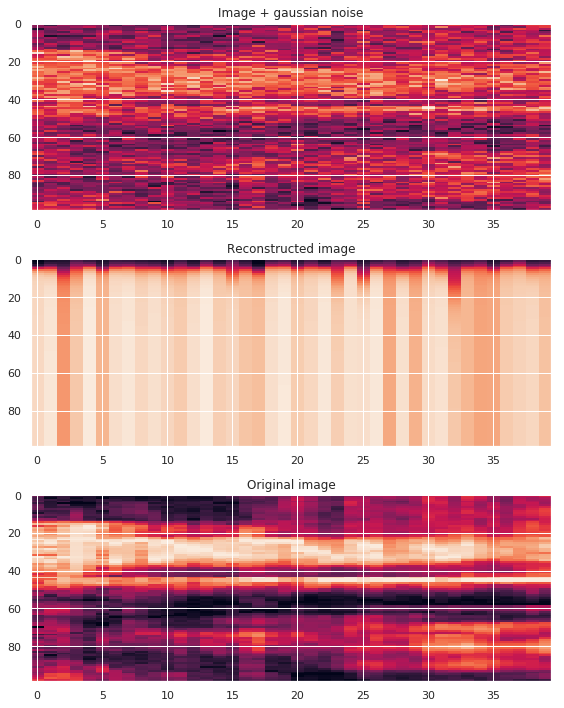

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,10))

ax1.imshow(image_noise, aspect="auto")
ax1.set_title("Image + gaussian noise")

ax2.imshow(denoised, aspect="auto")
ax2.set_title("Reconstructed image")

ax3.imshow(image, aspect="auto")
ax3.set_title("Original image")

plt.tight_layout()
plt.show()

In [0]:
def getFeatures(model, data):
    layer_name = 'Encoder'
    layer_out = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return layer_out.predict(data, use_multiprocessing=True)